<a href="https://colab.research.google.com/github/dtran556/dtran556/blob/main/artGenerator(real).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Foward Diffusion
Grab an image and then iteratively add more noise to the image until the image is fully noisy.

Backwards Diffusion
Grab an image and then iteratively reduce noise until the noisy image is pure.

Proof of concept using a DDPM Diffuser:
Cannot do backwards diffusion until the model is fully trained

Forward timesteps: tensor([  0, 100, 200, 300, 400, 500, 600, 700, 800, 900])


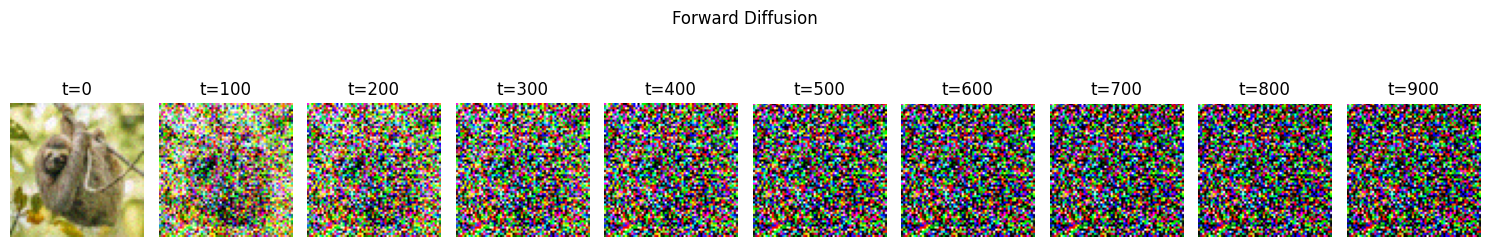

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from diffusers import DDPMScheduler
from PIL import Image
import torchvision.transforms as transforms
from datasets import load_dataset
from torch.utils.data import DataLoader
maxSteps = 1000
noiseScheduler = DDPMScheduler(num_train_timesteps=maxSteps,
                               beta_start=0.001,
                               beta_end=0.02)

def load_img():
    image_path = "/content/Sloth-RF.jpg"
    image = Image.open(image_path).convert('RGB')

    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor()
    ])

    return transform(image).numpy()

def plot_images(timesteps, images, title="Images"):
    fig, axes = plt.subplots(1, len(timesteps), figsize=(15, 3))
    for i, (t, img) in enumerate(zip(timesteps, images)):
        img_display = np.transpose(img, (1, 2, 0))
        img_display = np.clip(img_display, 0, 1)
        axes[i].imshow(img_display)
        axes[i].set_title(f"t={t}")
        axes[i].axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

image = torch.tensor(load_img())
forward_timesteps = torch.arange(0, maxSteps, maxSteps // 10)
print(f"Forward timesteps: {forward_timesteps}")

noise = torch.randn(image.shape)
noisyImage = noiseScheduler.add_noise(
    image.unsqueeze(0),
    noise.unsqueeze(0),
    forward_timesteps.unsqueeze(0)
).squeeze(0).numpy()

plot_images(forward_timesteps, noisyImage, "Forward Diffusion")

Import statements for the actual model:

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from diffusers import DDPMScheduler
from PIL import Image
import torchvision.transforms as transforms
from datasets import load_dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam


Training the model based off of this data set of 130k random images
https://huggingface.co/datasets/opendiffusionai/pexels-photos-janpf

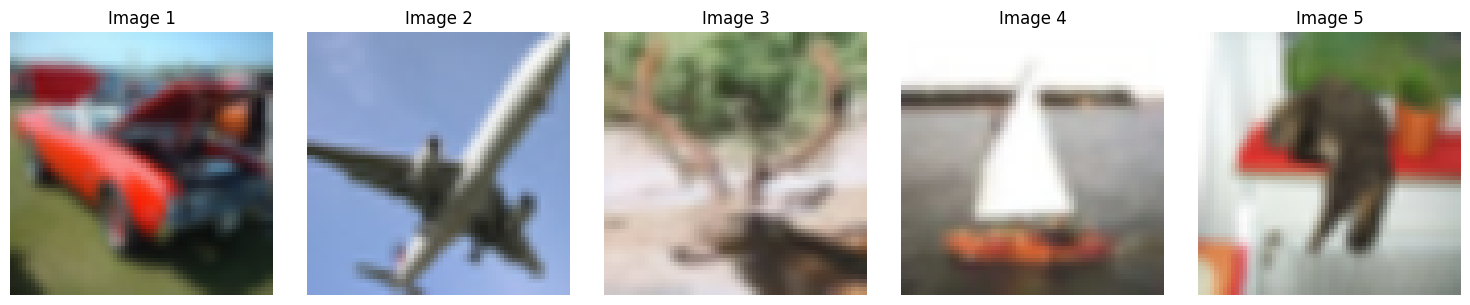

In [7]:
dataset = load_dataset("cifar10")

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

class CIFAR10Dataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset['train']
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item['img']

        if self.transform:
            image = self.transform(image)

        return image

cifar10_dataset = CIFAR10Dataset(dataset, transform=transform)
dataloader = DataLoader(cifar10_dataset, batch_size=1, shuffle=True)

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, image in enumerate(dataloader):
    if i >= 5:
        break

    img_display = image.squeeze(0).numpy()
    img_display = np.transpose(img_display, (1, 2, 0))
    img_display = np.clip(img_display, 0, 1)

    axes[i].imshow(img_display)
    axes[i].set_title(f"Image {i+1}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()


Training loop:


In [ ]:
maxSteps = 1000
noiseScheduler = DDPMScheduler(num_train_timesteps=maxSteps,
                               beta_start=0.001,
                               beta_end=0.02)
# Set device for Colab (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Check GPU memory
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

# Define SimpleUNet model
class SimpleUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)

        self.time_embed = nn.Linear(1, 256)

        self.upconv1 = nn.Conv2d(256, 128, 3, padding=1)
        self.upconv2 = nn.Conv2d(128, 64, 3, padding=1)
        self.out = nn.Conv2d(64, 3, 3, padding=1)

    def forward(self, x, timestep):
        # Downsampling
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))

        # Time embedding
        t_emb = self.time_embed(timestep.float().unsqueeze(-1))
        t_emb = t_emb.view(-1, 256, 1, 1)
        x = x + t_emb

        # Upsampling
        x = torch.relu(self.upconv1(x))
        x = torch.relu(self.upconv2(x))
        x = self.out(x)

        return x

# Initialize model and optimizer
unet_model = SimpleUNet().to(device)
optimizer = Adam(unet_model.parameters(), lr=1e-4)


max_timesteps = 1000
num_epochs = 25
batch_size = 32

print("Starting training...")
print(f"Model parameters: {sum(p.numel() for p in unet_model.parameters()):,}")

for epoch in range(num_epochs):
    epoch_loss = 0
    num_batches = 0

    for batch_idx, images in enumerate(dataloader):
        # Load Data
        images = images.to(device)
        img_shape = images.shape  # [Batch Size, Num Channels, W, H]

        # Run augmentations (simple random horizontal flip)
        if torch.rand(1) > 0.5:
            images = torch.flip(images, dims=[3])

        # Forward Diffusion
        # Generate Random Noise for Random timesteps
        timesteps = torch.randint(0, max_timesteps, (len(images),)).to(device)
        noise = torch.randn(img_shape).to(device)

        # Add noise to images
        noisy_images = noiseScheduler.add_noise(images, noise, timesteps)

        # UNet Forward Pass
        prediction = unet_model(noisy_images, timesteps)

        # Calculate Loss
        loss = F.mse_loss(prediction, noise)

        # Update Weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        num_batches += 1

        if batch_idx % 50 == 0:  # More frequent updates for Colab
            print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}, Loss: {loss.item():.4f}")

    avg_loss = epoch_loss / num_batches
    print(f"Epoch {epoch+1} completed. Average Loss: {avg_loss:.4f}")

print("Training completed!")

Using device: cuda
GPU: NVIDIA L4
GPU Memory: 23.8 GB
Starting training...
Model parameters: 741,891
Epoch 1/25, Batch 0, Loss: 6410.6670
Epoch 1/25, Batch 50, Loss: 21.4058
Epoch 1/25, Batch 100, Loss: 3.1327
Epoch 1/25, Batch 150, Loss: 1.0211
